In [1]:
CONFIRMED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
DEATHS = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
RECOVERED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
from doctest import testmod
from scipy.signal import savgol_filter

In [3]:
confirmed = pd.read_csv(CONFIRMED)
deaths = pd.read_csv(DEATHS)
recovered = pd.read_csv(RECOVERED)

In [4]:
confirmed = confirmed.set_index('Country/Region')
deaths = deaths.set_index('Country/Region')
recovered = recovered.set_index('Country/Region')

In [5]:
def prepare_data(dataset):
    data = dataset.iloc[:,3:].groupby(['Country/Region']).sum().transpose()
    data.index = pd.to_datetime(data.index)
    data = data.sort_index(ascending=True)
    data = pd.DataFrame(data)
    data = data.fillna(method='ffill')
    data = data.fillna(0)
    return data

In [6]:
def difference(dataset, interval=1):
    return dataset.apply(lambda x: x - x.shift(1)).fillna(method='ffill').fillna(0)

In [7]:
def weekly_moving_average(dataset, days=7):  
    return dataset.apply(lambda x: (x + x.shift(1) + x.shift(2) + x.shift(3)
                                    + x.shift(4) + x.shift(5)+ x.shift(6))/7).fillna(method='ffill')

In [8]:
# Adding population data
POPULATION_DATASET = '/Users/filippawlak/API_SP.POP.TOTL_DS2_en_excel_v2_2015410.xls'
population_dataset = pd.read_excel(POPULATION_DATASET, skiprows=3)
population = pd.DataFrame(population_dataset[['Country Name','2019']]).set_index('Country Name')
population.head()

,2019
Country Name,
Aruba,106314.0
Afghanistan,38041754.0
Angola,31825295.0
Albania,2854191.0
Andorra,77142.0


In [9]:
country_dict = {
    "Czechia" : "Czech Republic",
    "Slovakia" : "Slovak Republic",
}
def cases_per_100k(df):
    df_new = pd.DataFrame()
    for country in df:
        if country in country_dict:
            country2 = country_dict[country]
            country_population = population.loc[country2][0]
        else:
            country_population = population.loc[country][0]
        df_new[country] = df[country].apply(lambda x: x/country_population * 100000)
    return df_new    

In [10]:
def weekly_difference(dataset, days=7):  
    return dataset.apply(lambda x: (x - x.shift(7))/x.shift(7)*100).replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

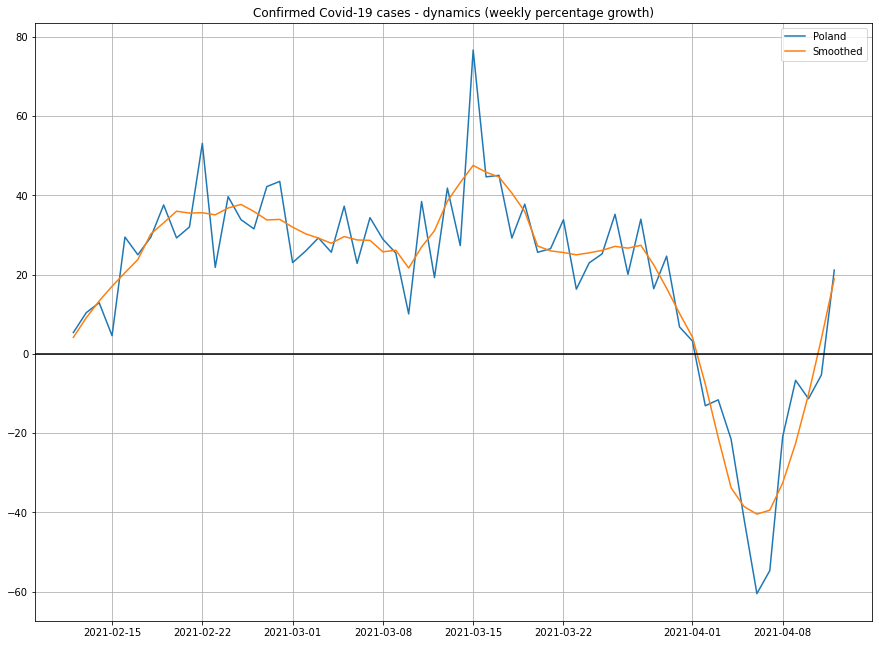

In [11]:
countries = ['Poland']
data = weekly_difference(difference(prepare_data(confirmed)))[countries].tail(60)
smoothed_data = savgol_filter(data['Poland'], 11, 3) # window size, polynomial order 3

plt.figure(figsize=(15,11))
plt.title('Confirmed Covid-19 cases - dynamics (weekly percentage growth)')
plt.plot(data.index, data['Poland'], label='Poland')
plt.plot(data.index, smoothed_data, label='Smoothed')
plt.axhline(0, color="black", linestyle="-")
plt.grid(True)
plt.legend()
plt.show()

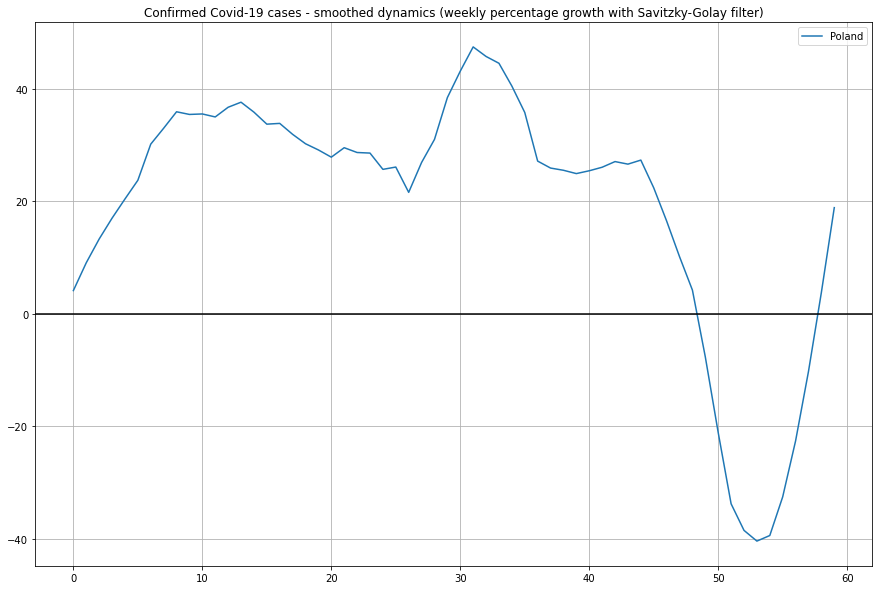

In [12]:
countries = ['Poland']
data = weekly_difference(difference(prepare_data(confirmed)))[countries].tail(60)

smoothed_data = savgol_filter(data['Poland'], 11, 3) # window size 11, polynomial order 3

plt.figure(figsize=(15,10))
plt.title('Confirmed Covid-19 cases - smoothed dynamics (weekly percentage growth with Savitzky-Golay filter)')
plt.plot(smoothed_data)
plt.axhline(0, color="black", linestyle="-")
plt.grid(True)
plt.legend(data.columns)
plt.show()


In [13]:
from scipy.signal import savgol_filter
def smoothed_data(dataset, window_size=11, polynomial_order=3):
    df_new = pd.DataFrame(index=dataset.index)
    for country in dataset.columns:
        df_new[country] = savgol_filter(dataset[country], window_size, polynomial_order)
    return df_new

In [14]:
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia']
data = weekly_difference(difference(prepare_data(confirmed)))[countries].tail(10)
data

Country/Region,Poland,Italy,Czechia,Portugal,Slovakia
2021-04-03,-11.606159,-10.854242,-49.844439,-18.604651,-51.143044
2021-04-04,-21.554022,-8.095287,-46.057884,-47.123288,-32.972973
2021-04-05,-41.548341,-17.209302,10.384395,-48.543689,-22.926829
2021-04-06,-60.473588,-51.647462,-79.335847,125.257732,-72.592593
2021-04-07,-54.674531,-42.705237,-36.149584,7.281553,-37.412399
2021-04-08,-20.886166,-22.426073,-2.937543,1.689189,20.858896
2021-04-09,-6.686094,-13.656066,-15.092830,26.642336,-33.357401
2021-04-10,-11.331172,-17.395397,24.554148,114.642857,44.385027
2021-04-11,-5.335831,-12.654715,2.543941,193.264249,-5.000000
2021-04-12,21.116823,-8.426966,-48.284823,70.440252,-32.911392


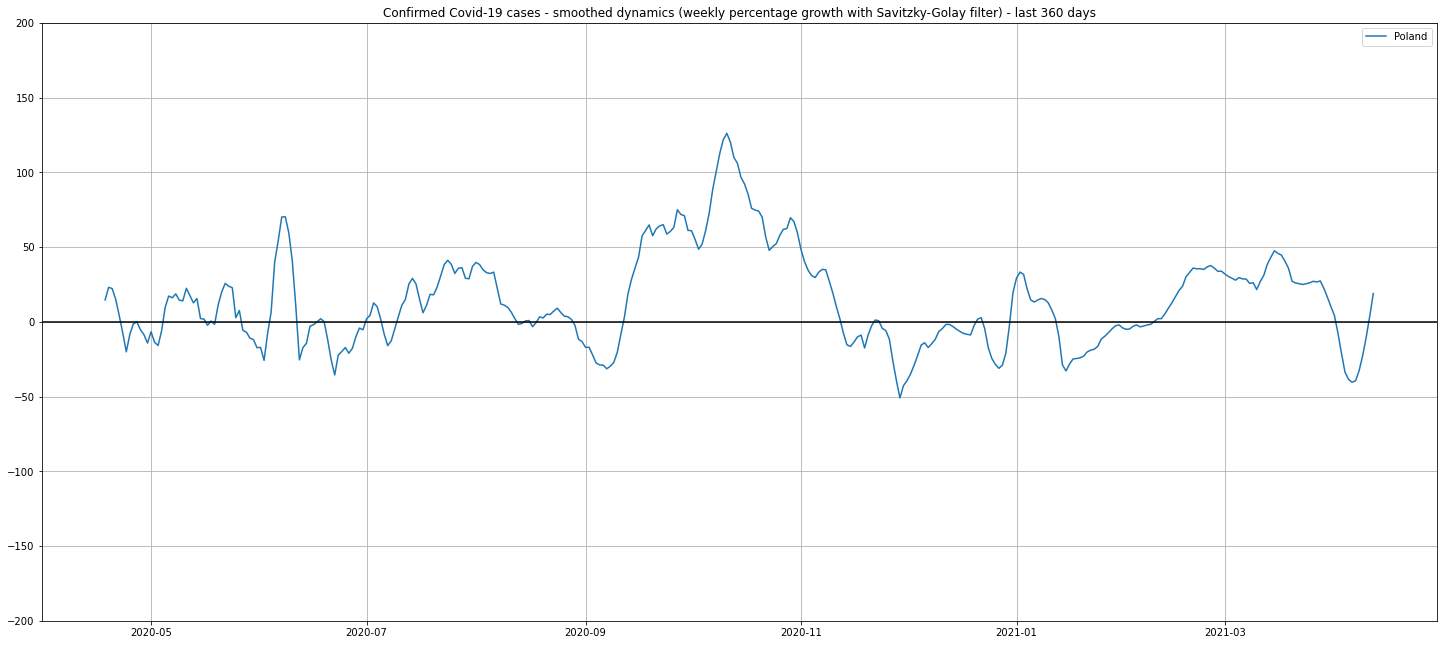

In [15]:
countries = ['Poland']
# countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia']
data = weekly_difference(difference(prepare_data(confirmed)))[countries].tail(360)
smooth_confirmed = smoothed_data(data)
plt.figure(figsize=(25,11))
plt.title('Confirmed Covid-19 cases - smoothed dynamics (weekly percentage growth with Savitzky-Golay filter) - last 360 days')
plt.plot(smooth_confirmed)
plt.axhline(0, color="black", linestyle="-")
plt.ylim(-200, 200)
plt.grid(True)
plt.legend(smooth_confirmed.columns)
plt.show()

In [16]:
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia','United Kingdom']
data = difference(prepare_data(confirmed))
data.loc[pd.to_datetime('today').normalize(), 'Poland'] = 28073
weekly_difference(data[countries]).tail(20)

Country/Region,Poland,Italy,Czechia,Portugal,Slovakia,United Kingdom
2021-03-25,25.210823,-4.899402,-26.413369,-12.783505,-18.921569,-0.868604
2021-03-26,35.193876,-6.344575,-25.578346,-14.084507,-24.240619,27.976190
2021-03-27,20.044602,-0.330364,-20.556128,-24.726477,-14.707521,-30.679198
2021-03-28,33.940503,-2.200050,-60.477270,-18.888889,0.000000,-26.306945
2021-03-29,16.420879,-47.349088,-178.726287,24.596774,-48.877805,-11.540596
2021-03-30,24.623656,-14.323070,-15.953687,-10.599078,-5.152225,-24.847702
2021-03-31,6.782027,12.430575,-21.035363,7.478261,-6.170966,-26.857448
2021-04-01,3.229868,-6.321524,-17.692916,39.952719,-21.160822,-27.274176
2021-04-02,-13.100014,-8.967436,-21.369242,12.295082,8.883648,-45.116279
2021-04-03,-11.606159,-10.854242,-49.844439,-18.604651,-51.143044,-12.407265


In [17]:
# Daily monitoring

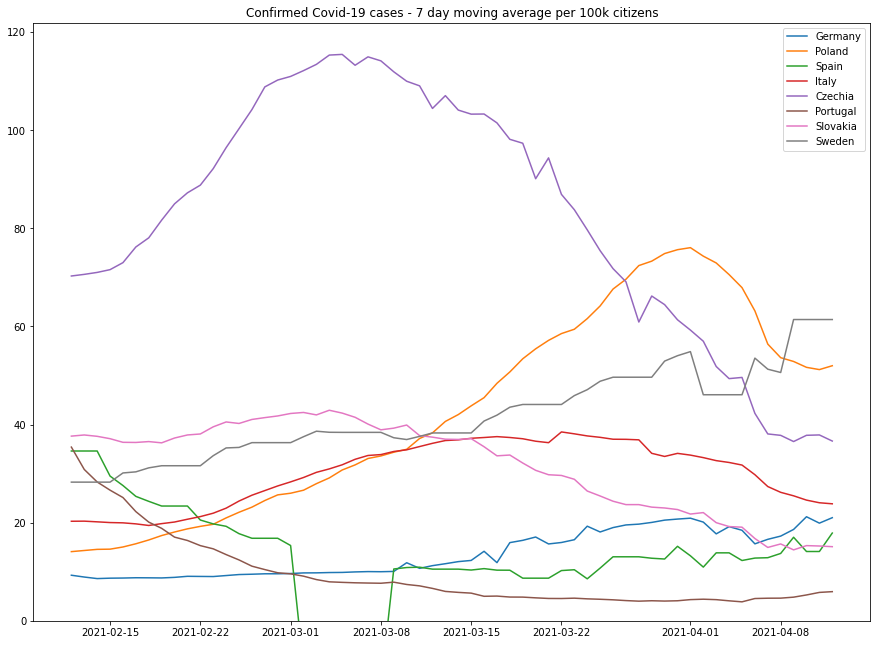

In [18]:
countries = ['Germany', 'Poland', 'Spain','Italy', 'Czechia', 'Portugal', 'Slovakia','Sweden']
cases_per_popul = cases_per_100k(weekly_moving_average(difference(prepare_data(confirmed)))[countries]).tail(60)
plt.figure(figsize=(15,11))
plt.title('Confirmed Covid-19 cases - 7 day moving average per 100k citizens')
plt.plot(cases_per_popul)
plt.ylim(0, None)
plt.legend(cases_per_popul.columns)
plt.show()

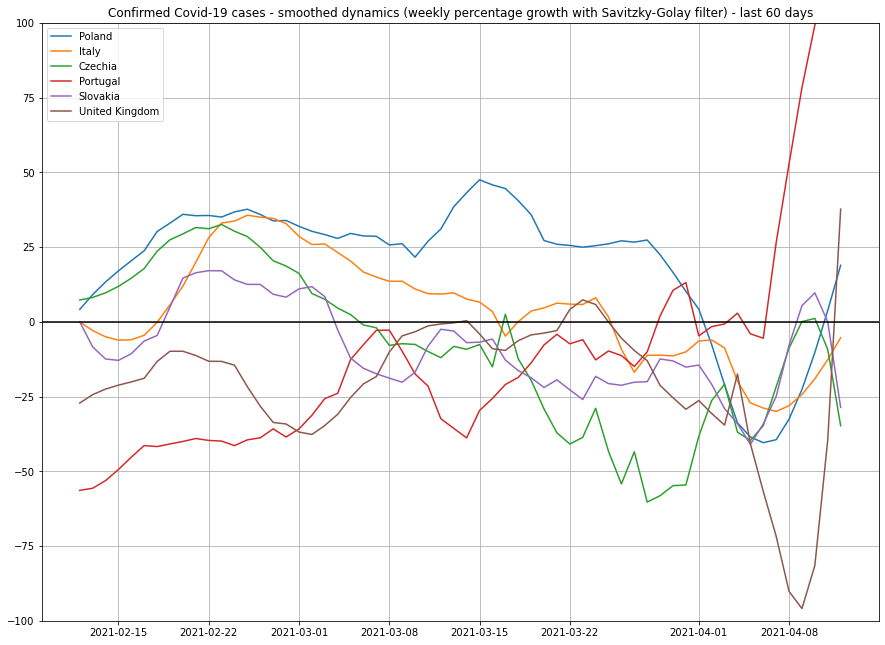

In [19]:
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia','United Kingdom']
weekly_dynamics = weekly_difference(difference(prepare_data(confirmed)))[countries].tail(60)
smooth_confirmed = smoothed_data(weekly_dynamics)
plt.figure(figsize=(15,11))
plt.title('Confirmed Covid-19 cases - smoothed dynamics (weekly percentage growth with Savitzky-Golay filter) - last 60 days')
plt.plot(smooth_confirmed)
plt.axhline(0, color="black", linestyle="-")
plt.ylim(-100, 100)
plt.grid(True)
plt.legend(smooth_confirmed.columns)
plt.show()

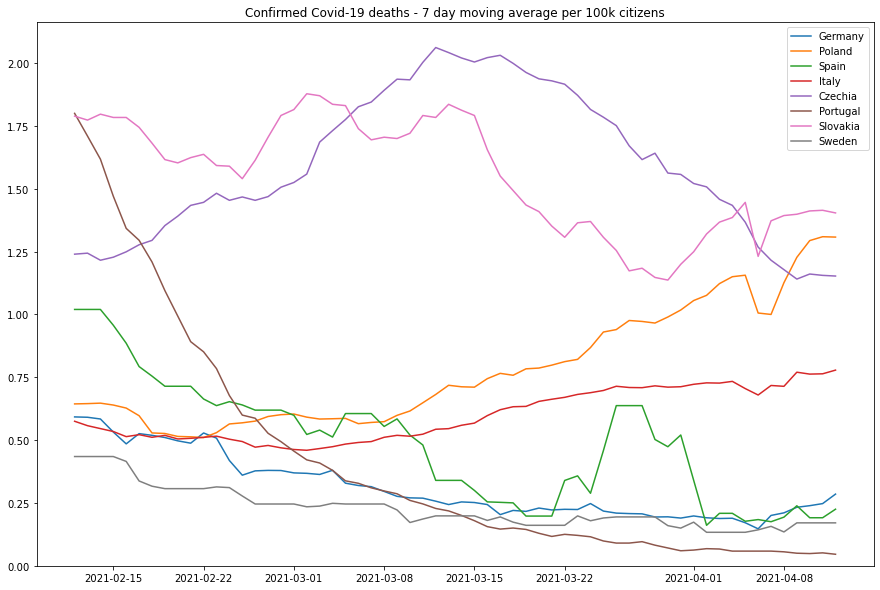

In [20]:
# deaths
countries = ['Germany', 'Poland', 'Spain','Italy', 'Czechia', 'Portugal', 'Slovakia','Sweden']
cases_per_popul = cases_per_100k(weekly_moving_average(difference(prepare_data(deaths)))[countries]).tail(60)
plt.figure(figsize=(15,10))
plt.title('Confirmed Covid-19 deaths - 7 day moving average per 100k citizens')
plt.plot(cases_per_popul)
plt.ylim(0, None)
plt.legend(cases_per_popul.columns)
plt.show()

In [21]:
# Adding today data for Poland
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia','United Kingdom', 'Sweden']
today_data = difference(prepare_data(confirmed))
today_data.loc[pd.to_datetime('today').normalize(), 'Poland'] = 13277   # Today cases for Poland
today_data[countries].tail(20)

Country/Region,Poland,Italy,Czechia,Portugal,Slovakia,United Kingdom,Sweden
2021-03-25,34150.0,23681.0,8851.0,423.0,1654.0,6277.0,7706.0
2021-03-26,35145.0,24076.0,7946.0,488.0,1272.0,6235.0,6328.0
2021-03-27,31759.0,23834.0,7714.0,344.0,1531.0,3909.0,0.0
2021-03-28,29266.0,19604.0,4008.0,365.0,925.0,3947.0,0.0
2021-03-29,16973.0,12900.0,1743.0,309.0,205.0,4783.0,0.0
2021-03-30,20862.0,16055.0,6896.0,388.0,1215.0,4071.0,16427.0
2021-03-31,32891.0,23887.0,8664.0,618.0,1855.0,4115.0,8441.0
2021-04-01,35253.0,22184.0,7285.0,592.0,1304.0,4565.0,8305.0
2021-04-02,30541.0,21917.0,6248.0,548.0,1385.0,3422.0,0.0
2021-04-03,28073.0,21247.0,3869.0,280.0,748.0,3424.0,0.0


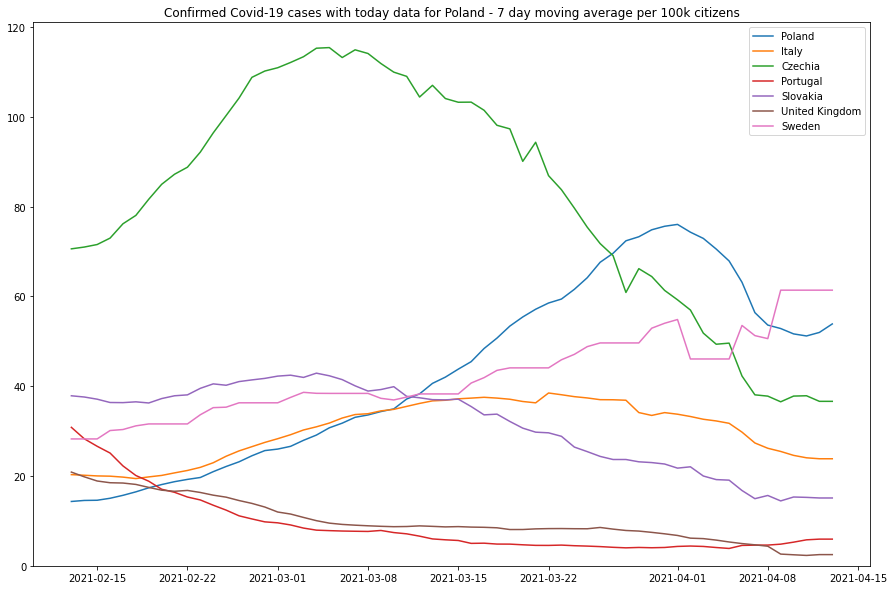

In [22]:
# With today data for Poland
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia','United Kingdom', 'Sweden']
today_per_100k = cases_per_100k(weekly_moving_average(today_data)[countries].fillna(method='ffill')).tail(60)
plt.figure(figsize=(15,10))
plt.title('Confirmed Covid-19 cases with today data for Poland - 7 day moving average per 100k citizens')
plt.plot(today_per_100k)
plt.ylim(0, None)
plt.legend(today_per_100k.columns)
plt.show()

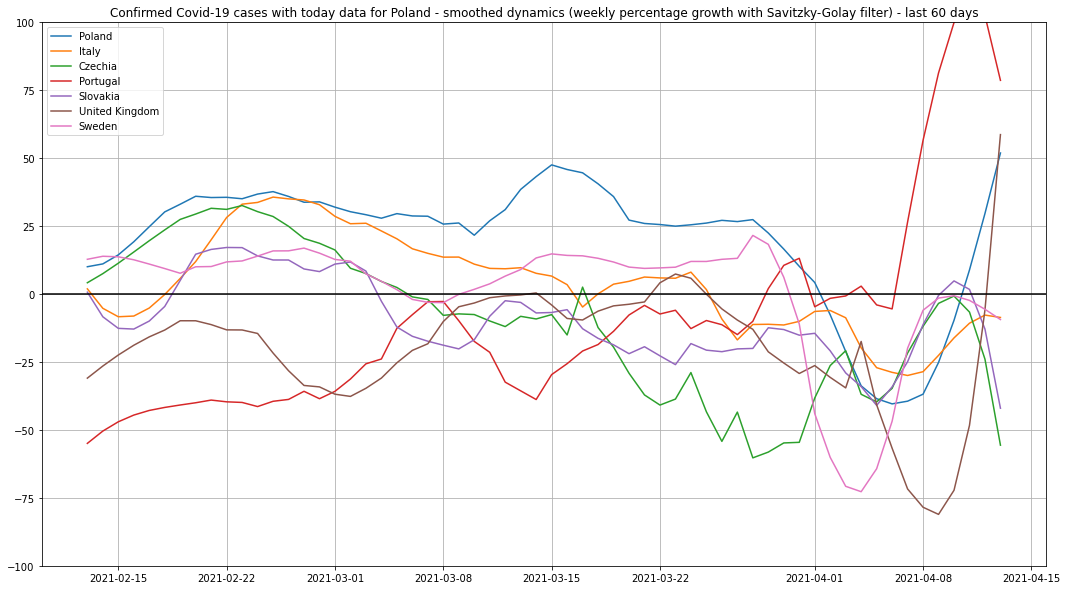

In [23]:
# With today data for Poland
countries = ['Poland', 'Italy', 'Czechia', 'Portugal', 'Slovakia','United Kingdom', 'Sweden']
smooth_confirmed = smoothed_data((weekly_difference(today_data[countries]).fillna(method='ffill')).tail(60))

plt.figure(figsize=(18,10))
plt.title('Confirmed Covid-19 cases with today data for Poland - smoothed dynamics (weekly percentage growth with Savitzky-Golay filter) - last 60 days')
plt.plot(smooth_confirmed)
plt.axhline(0, color="black", linestyle="-")
plt.ylim(-100, 100)
plt.grid(True)
plt.legend(smooth_confirmed.columns)
plt.show()

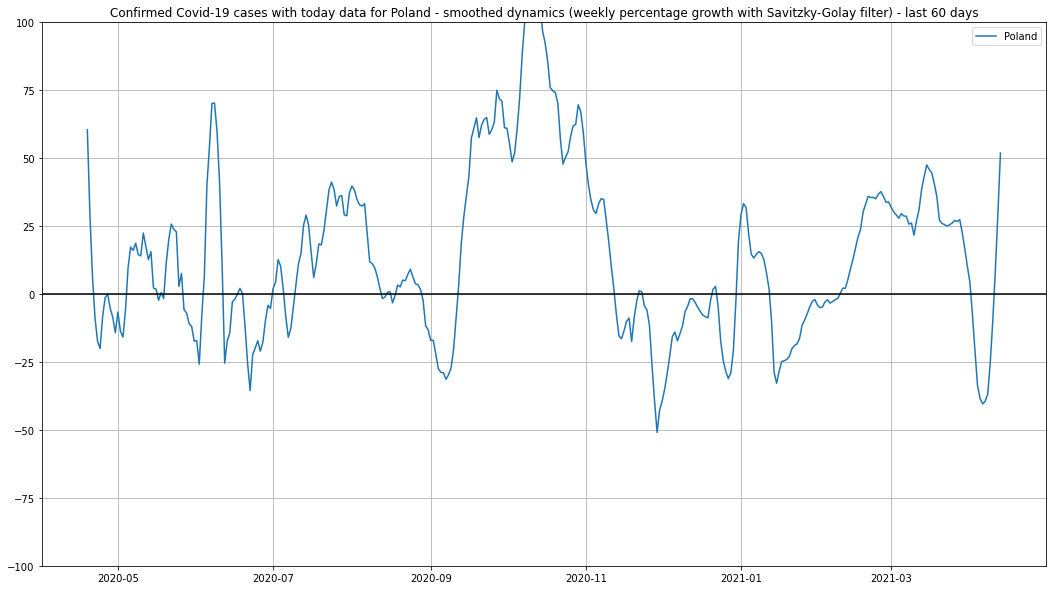

In [24]:
# With today data for Poland
countries = ['Poland']
smooth_confirmed = smoothed_data((weekly_difference(today_data[countries]).fillna(method='ffill')).tail(360))

plt.figure(figsize=(18,10))
plt.title('Confirmed Covid-19 cases with today data for Poland - smoothed dynamics (weekly percentage growth with Savitzky-Golay filter) - last 60 days')
plt.plot(smooth_confirmed)
plt.axhline(0, color="black", linestyle="-")
plt.ylim(-100, 100)
plt.grid(True)
plt.legend(smooth_confirmed.columns)
plt.show()

In [25]:
# High scores in Poland
pol_deaths = difference(prepare_data(deaths))['Poland']
pol_cases = difference(prepare_data(confirmed))['Poland']
print('High scores (without today data):')
print(f'max deaths: {int(max(pol_deaths))}')
print(f'max confirmed cases: {int(max(pol_cases))}')

High scores (without today data):
max deaths: 956
max confirmed cases: 35253


In [26]:
# One week forecast for Poland

# Average dynamic in Poland for last 7 days

pol_weekly_dynamic = weekly_difference(difference(prepare_data(confirmed)))['Poland']
pol_avg_dynamic = pol_weekly_dynamic.tail(7).mean()
1 + pol_avg_dynamic/100

0.8024706296632766

In [27]:
pol_last_7d = difference(prepare_data(confirmed))['Poland'].tail(7)
pol_last_7d

2021-04-06     8246.0
2021-04-07    14908.0
2021-04-08    27890.0
2021-04-09    28499.0
2021-04-10    24892.0
2021-04-11    21733.0
2021-04-12    12016.0
Name: Poland, dtype: float64

In [28]:
pol_last_7d = difference(prepare_data(confirmed))['Poland'].tail(7)
pol_last_7d.index = pol_last_7d.index + timedelta(7)
pol_last_7d = pol_last_7d.apply(lambda x: int(np.round(x*(1 + pol_avg_dynamic/100))))
pol_last_7d = pd.DataFrame(pol_last_7d)
pol_last_7d['Day_of_week'] = pol_last_7d.index.day_name()
pol_last_7d

,Poland,Day_of_week
2021-04-13,6617,Tuesday
2021-04-14,11963,Wednesday
2021-04-15,22381,Thursday
2021-04-16,22870,Friday
2021-04-17,19975,Saturday
2021-04-18,17440,Sunday
2021-04-19,9642,Monday


In [29]:
# Błędy prognozy



In [30]:
def one_day_forecast(dataset):
    dataset = pd.DataFrame(dataset)
    dataset = dataset.apply(lambda x: round(x.shift(7)*(1+(x.shift(1) - x.shift(8))/x.shift(8))))
    dataset = dataset.replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)
    return dataset

In [31]:
one_day_forecast(difference(prepare_data(confirmed))['Poland']).tail(20)

,Poland
2021-03-24,29136
2021-03-25,33533
2021-03-26,32550
2021-03-27,35767
2021-03-28,26230
2021-03-29,19527
2021-03-30,19489
2021-03-31,38387
2021-04-01,36466
2021-04-02,36280


In [32]:
pd.DataFrame(difference(prepare_data(confirmed))['Poland']).tail(20)



,Poland
2021-03-24,30802.0
2021-03-25,34150.0
2021-03-26,35145.0
2021-03-27,31759.0
2021-03-28,29266.0
2021-03-29,16973.0
2021-03-30,20862.0
2021-03-31,32891.0
2021-04-01,35253.0
2021-04-02,30541.0


In [33]:
# plt.figure(figsize=(15,11))
# plt.title('One day forecast basing on dynamic from the day before')
# plt.plot(one_day_forecast(difference(prepare_data(confirmed))['Poland'].tail(60)),  label='one day forecast')
# plt.plot(difference(prepare_data(confirmed))['Poland'].tail(60), label='original data')
# plt.ylim(0, None)
# plt.legend()
# plt.show()

In [34]:
def simple_weekly_forecast(dataset):
    dataset = pd.DataFrame(dataset)
    dataset = dataset.apply(lambda x: round(x.shift(7)*(1+(x.shift(1) - x.shift(8))/x.shift(8))))
    dataset = dataset.replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)
    return dataset

In [35]:
# for day in difference(prepare_data(confirmed))['Poland'].index:
#     if day.day_name()=='Sunday':
#         print(day, difference(prepare_data(confirmed))['Poland'].loc[day])
    

In [36]:
# for day in difference(prepare_data(confirmed))['Poland'].index:
#     if day.day_name()=='Sunday' and day > min(difference(prepare_data(confirmed))['Poland'].index)+timedelta(6):
#         dynamic = weekly_difference(difference(prepare_data(confirmed)))['Poland'].loc[day]
#         sum_dynamic = 0
#         for i in range(0, 6):
#             sum_dynamic = sum_dynamic + weekly_difference(difference(prepare_data(confirmed)))['Poland'].loc[day - timedelta(i)]
#         average_dynamic = sum_dynamic/7
#         print(day, difference(prepare_data(confirmed))['Poland'].loc[day], f'dynamika {np.round(dynamic)}', f'średnia dynamika {np.round(average_dynamic)}')

In [37]:
# forecast = pd.Series()
# for day in difference(prepare_data(confirmed))['Poland'].index:
#     if day.day_name()=='Sunday' and day > min(difference(prepare_data(confirmed))['Poland'].index)+timedelta(6):
#         sum_dynamic = 0
#         for i in range(0, 6):   # calculating average dynamic
#             sum_dynamic = sum_dynamic + weekly_difference(difference(prepare_data(confirmed)))['Poland'].loc[day - timedelta(i)]
#         average_dynamic = sum_dynamic/7
#         for i in range(0, 6):   # calculating forecast for the n-th week
#             forecast[day - timedelta(i) + timedelta(7)] = difference(prepare_data(confirmed))['Poland'].loc[day - timedelta(i)] * average_dynamic
# print(forecast)

In [38]:
# # uprościć i dodać błąd i średni błąd tygodniowy
# for day in difference(prepare_data(confirmed))['Poland'].index:
#     if day.day_name()=='Sunday' and day > min(difference(prepare_data(confirmed))['Poland'].index)+timedelta(6):
#         sum_dynamic = 0
#         for i in range(0, 7):   # calculating average dynamic
#             sum_dynamic = sum_dynamic + weekly_difference(difference(prepare_data(confirmed)))['Poland'].loc[day - timedelta(i)]
#         average_dynamic = sum_dynamic/7
# #         forecast = pd.Series()
#         for i in range(0, 7):   # calculating forecast for the n-th week
# #             forecast[day - timedelta(i) + timedelta(7)] = difference(prepare_data(confirmed))['Poland'].loc[day - timedelta(i)] * average_dynamic
#             print(f"index: {day - timedelta(i) + timedelta(7)}, forecast: {difference(prepare_data(confirmed))['Poland'].loc[day - timedelta(i)] * (1 +average_dynamic/100)}, avg. dynamic:{average_dynamic}, wartość rzeczywista: {difference(prepare_data(confirmed))['Poland'].loc[day - timedelta(i) + timedelta(7)]}")
#         print('##############################')